<a href="https://colab.research.google.com/github/John-G-Thomas/DS-Unit-1-Sprint-1-Data-Wrangling-and-Storytelling/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
import numpy as np
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from pandas_profiling import ProfileReport
import plotly.express as px
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split, cross_val_predict

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [3]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [4]:
from sklearn.model_selection import cross_val_predict

In [5]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)

In [6]:
import numpy as np
def clean(X):
    X = X.copy()   
    # anything around zero needs to be 0 to remove
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    # drop duplicates
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    # replace the zeros with nulls
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)        
    # convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    # Get more precise dates to increase accuracy 
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    # Now you can get another important feature based on age since construction
    X['years'] = X['year_recorded'] - X['construction_year']
    X['age'] = X['years'].isnull()
    # Drop High cardinality
    X = X.drop(['scheme_name','funder','installer'], axis=1)
    # drop low variance column
    X = X.drop(['recorded_by'], axis=1)
    # return the cleaned dataframe
    return X
train = clean(train)
val = clean(val)
test = clean(test)

In [7]:
# the status_group column is the target
target = 'status_group'

# get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()
# Get a list of all categorical features with cardinality >=50
high_cardinality= cardinality[cardinality > 50].index.tolist()
# combine the lists 
features = numeric_features + categorical_features
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'year_recorded', 'month_recorded', 'day_recorded', 'years', 'basin', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group', 'age']


In [8]:
# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test
y_test = test[features]

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(47520, 33)
(47520,)
(11880, 33)
(11880,)
(14358, 38)


In [10]:
model = Pipeline([
                  ('ohe', OneHotEncoder()),
                  ('impute', SimpleImputer()),
                  ('classifier', RandomForestClassifier(n_jobs=-1))
])

model.fit(X_train, y_train)

print('training accuracy:', model.score(X_train, y_train))
print('validation accuracy:', model.score(X_val, y_val))

training accuracy: 0.9979166666666667
validation accuracy: 0.8061447811447812


In [11]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(random_state=0, n_jobs=-1, criterion='entropy', n_estimators=300, oob_score=True))
pipeline.fit(X_train, y_train)
print('training accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

training accuracy: 0.9979377104377104
Validation Accuracy 0.8104377104377104


In [12]:
y_train = y_train != 'functional'
y_val = y_val  != 'functional'

In [13]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

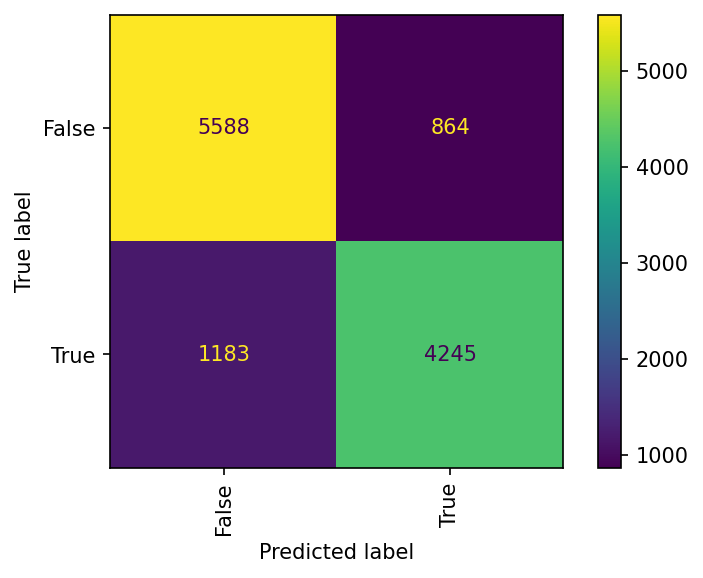

In [14]:
from sklearn.metrics import plot_confusion_matrix, classification_report

plt.rcParams['figure.dpi'] = 150
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.87      0.85      6452
        True       0.83      0.78      0.81      5428

    accuracy                           0.83     11880
   macro avg       0.83      0.82      0.83     11880
weighted avg       0.83      0.83      0.83     11880



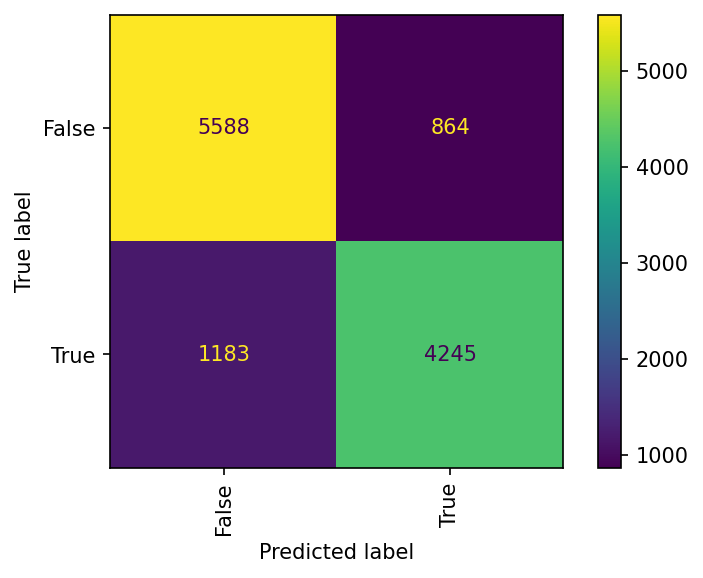

In [16]:
plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [17]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.83      0.87      0.85      6452
        True       0.83      0.78      0.81      5428

    accuracy                           0.83     11880
   macro avg       0.83      0.82      0.83     11880
weighted avg       0.83      0.83      0.83     11880



In [18]:
y_pred = pipeline.predict(X_val)
y_pred_proba = pipeline.predict_proba(X_val)

In [19]:
y_pred.shape

(11880,)

In [20]:
y_pred

array([ True, False, False, ...,  True, False,  True])

In [21]:
submission = sample_submission.copy()
submission['status_group'] = y_pred

ValueError: ignored

In [ ]:
from google.colab import files
submission.to_csv('my7submission.csv', index=False)
files.download('my7submission.csv')

In [22]:
pipeline = Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'source_type'
                                      'source_class', 'waterpoint_type']
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=22, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=29, n_jobs=-1,
                                        oob_score=True, random_state=0,
                                        verbose=0, warm_start=False)],
         verbose=False)

SyntaxError: ignored

In [23]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'source_type'
                                      'source_class', 'waterpoint_type']), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=22, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=29, n_jobs=-1,
                                        oob_score=True, random_state=0,
                                        verbose=0, warm_start=False))
pipeline.fit(X_train, y_train)
print('training accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy', pipeline.score(X_val, y_val))

KeyError: ignored